### Plot station timeseries

#### Purpose: Plot timeseries of SIT at Hausgarten stations

#### Modules and functions

In [1]:
import numpy as np
import pylab as plt
import xarray as xr
import os,sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import pandas as pd
import datetime
import glob
import matplotlib.dates as mdates
import calendar
from scipy.stats import linregress

In [2]:
def makenice(ax):
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('SIT', fontsize=14)
    #ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())

In [3]:
def convert_to_decimal_degrees(coord_str):
    # Remove the degree symbol and split the string
    degree_str, minute_str_with_direction = coord_str.split('°')
    minute_str, direction = minute_str_with_direction.split("'")

    # Remove any commas from the minute string and convert to float
    minutes = float(minute_str.replace(',', '.'))

    # Convert degree string to float
    degrees = float(degree_str)

    # Calculate decimal degrees
    decimal_degrees = degrees + minutes / 60

    # If the direction is 'S' or 'W', make the decimal degrees negative
    if direction.strip() in ['S', 'W']:
        decimal_degrees = -decimal_degrees

    return decimal_degrees

In [4]:
def get_coorddicts(df):
    londict = {stationname:np.round(lon,3) for stationname,lon in zip(df["Station ID"],df["lon_decimal"])}
    latdict = {stationname:np.round(lat,3) for stationname,lat in zip(df["Station ID"],df["lat_decimal"])}
    return londict,latdict

In [41]:
date_range = pd.date_range(start='1999-01', end='2024-12', freq='MS')

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=312, freq='MS')

In [66]:
def makeplot(ax,df_station):
    date_range = pd.date_range(start='1999-01', end='2024-12', freq='MS')

    cutoff_date = pd.Timestamp('2010-04')
    
    # Mask the data based on the cutoff date
    dates_envisat = date_range <= cutoff_date
    dates_cs2smos = date_range > cutoff_date
    mean_line, = ax.plot(date_range[dates_envisat], df_station["sit_mean"].values[dates_envisat], 
                          label='ENVISAT', color='red', linestyle='-', 
                          marker='o', markersize=6, linewidth=2, alpha=0.8)
    mean_line, = ax.plot(date_range[dates_cs2smos], df_station["sit_mean"].values[dates_cs2smos], 
                          label='CS2-SMOS', color='royalblue', linestyle='-', 
                          marker='o', markersize=6, linewidth=2, alpha=0.8)
    # Define th
    # Customize the plot
    ax.set_title(f'{df_station["station_id"][0]}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('SIT', fontsize=14)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Improve x-axis formatting
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    
    ax.set_ylim(0, 3.5)
    ax.set_xlim(date_range[0],date_range[-1])

In [51]:
def design_map(ax,title,hemisphere,extent = [-30, 30, 58,85]):
    if hemisphere == "nh":
        ax.set_extent(extent, ccrs.PlateCarree())
    elif hemisphere == "sh":
        ax.set_extent([-180, 180, -60,-90], ccrs.PlateCarree())
    else:
        sys.exit("Hemisphere needs to be either 'nh' or 'sh'!")
    ax.set_title(title,fontsize = 14) # set title
    ax.coastlines()
    ax.gridlines()
    #ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5E5A0')  # Adjust facecolor as needed
    #ax.set_facecolor('#F5F5F5')
    #ax.gridlines().label_style = {'fontsize': 14}
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, alpha=0.5, linestyle='--', draw_labels=True)
    #gl.xlabel_style = {'size': 14, 'color': 'black'}
    #gl.ylabel_style = {'size': 14, 'color': 'black'}

In [85]:
def get_dfdict(datadir,station_ids,firstyear,lastyear):
    dfdict = {}
    for station_id in station_ids:
        if os.path.exists(os.path.join(datadir,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv")):
            df_station = pd.read_csv(os.path.join(datadir,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv"))
        df_station["sit_mean"][df_station["sit_mean"]>30] = np.nan
        dfdict[station_id] = df_station
    return dfdict

In [8]:
def get_dirs():
    if os.path.exists("/Users/vludwig/"):
        basedir = "/Users/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/Users/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        #datadir_nc = os.path.join(basedir,"02_NETCDF/01_MONTHLY")
        datadir_nc = os.path.join(basedir,"02_NETCDF/02_MONTHLY_OWN")
    else:
        basedir = "/albedo/work/user/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/albedo/home/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        datadir_nc = "/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/"
    return basedir,plotdir,datadir_csv,datadir_nc

#### Load data

In [9]:
firstyear = 1999
lastyear = 2024


In [10]:
today = datetime.datetime.strftime(datetime.datetime.now(),"%Y%m%d")

In [11]:
basedir,plotdir_tmp,datadir_csv,datadir_nc = get_dirs()
plotdir = os.path.join(plotdir_tmp,"01_TIMESERIES")

#### Plot timeseries

In [14]:

df_hausgarten = pd.read_excel(os.path.join(datadir_csv,"average HG-Stations.xlsx"))
station_ids = ['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']
# Select rows where "Station ID" is in the specified list
hausgarten_ice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids)]
hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
londict,latdict = get_coorddicts(hausgarten_ice)
station_ids_by_lon = sorted(londict, key=lambda k: londict[k])

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/465570064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/465570064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]


##### One plot per station

In [37]:
## Stations separately
for station_id in station_ids:
    fig, ax = plt.subplots(figsize=(12, 6))
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv")):
        print(f"Station {station_id}")
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv"))
        df_station[df_station["sit_mean"]>30] = np.nan
        print(np.nanpercentile(df_station["sit_mean"][~np.isnan(df_station["sit_mean"])],90))
        makeplot(ax,df_station)
        plt.tight_layout()
        fig.savefig(os.path.join(plotdir,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
# Plot the mean values with error bars
        plt.close(fig)

Station EG-I
2.10567626953125
Station EG-II
2.076627074432373
Station EG-III
2.076627074432373
Station EG-IV
1.618360710144043
Station N3
1.3230337142944342
Station N4
1.5339297294616698
Station N5
1.6081859912872314


In [16]:
viridis_colors = plt.cm.viridis(np.linspace(0,1,len(station_ids)))

In [17]:
axpos = [7,5,3,1,6,4,2]

In [24]:
df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sit_mean_EG-I_{firstyear}-{lastyear}.csv"))

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/820109679.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_station["sit_mean"][df_station["sit_mean"]>30] = np.nan
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipyke

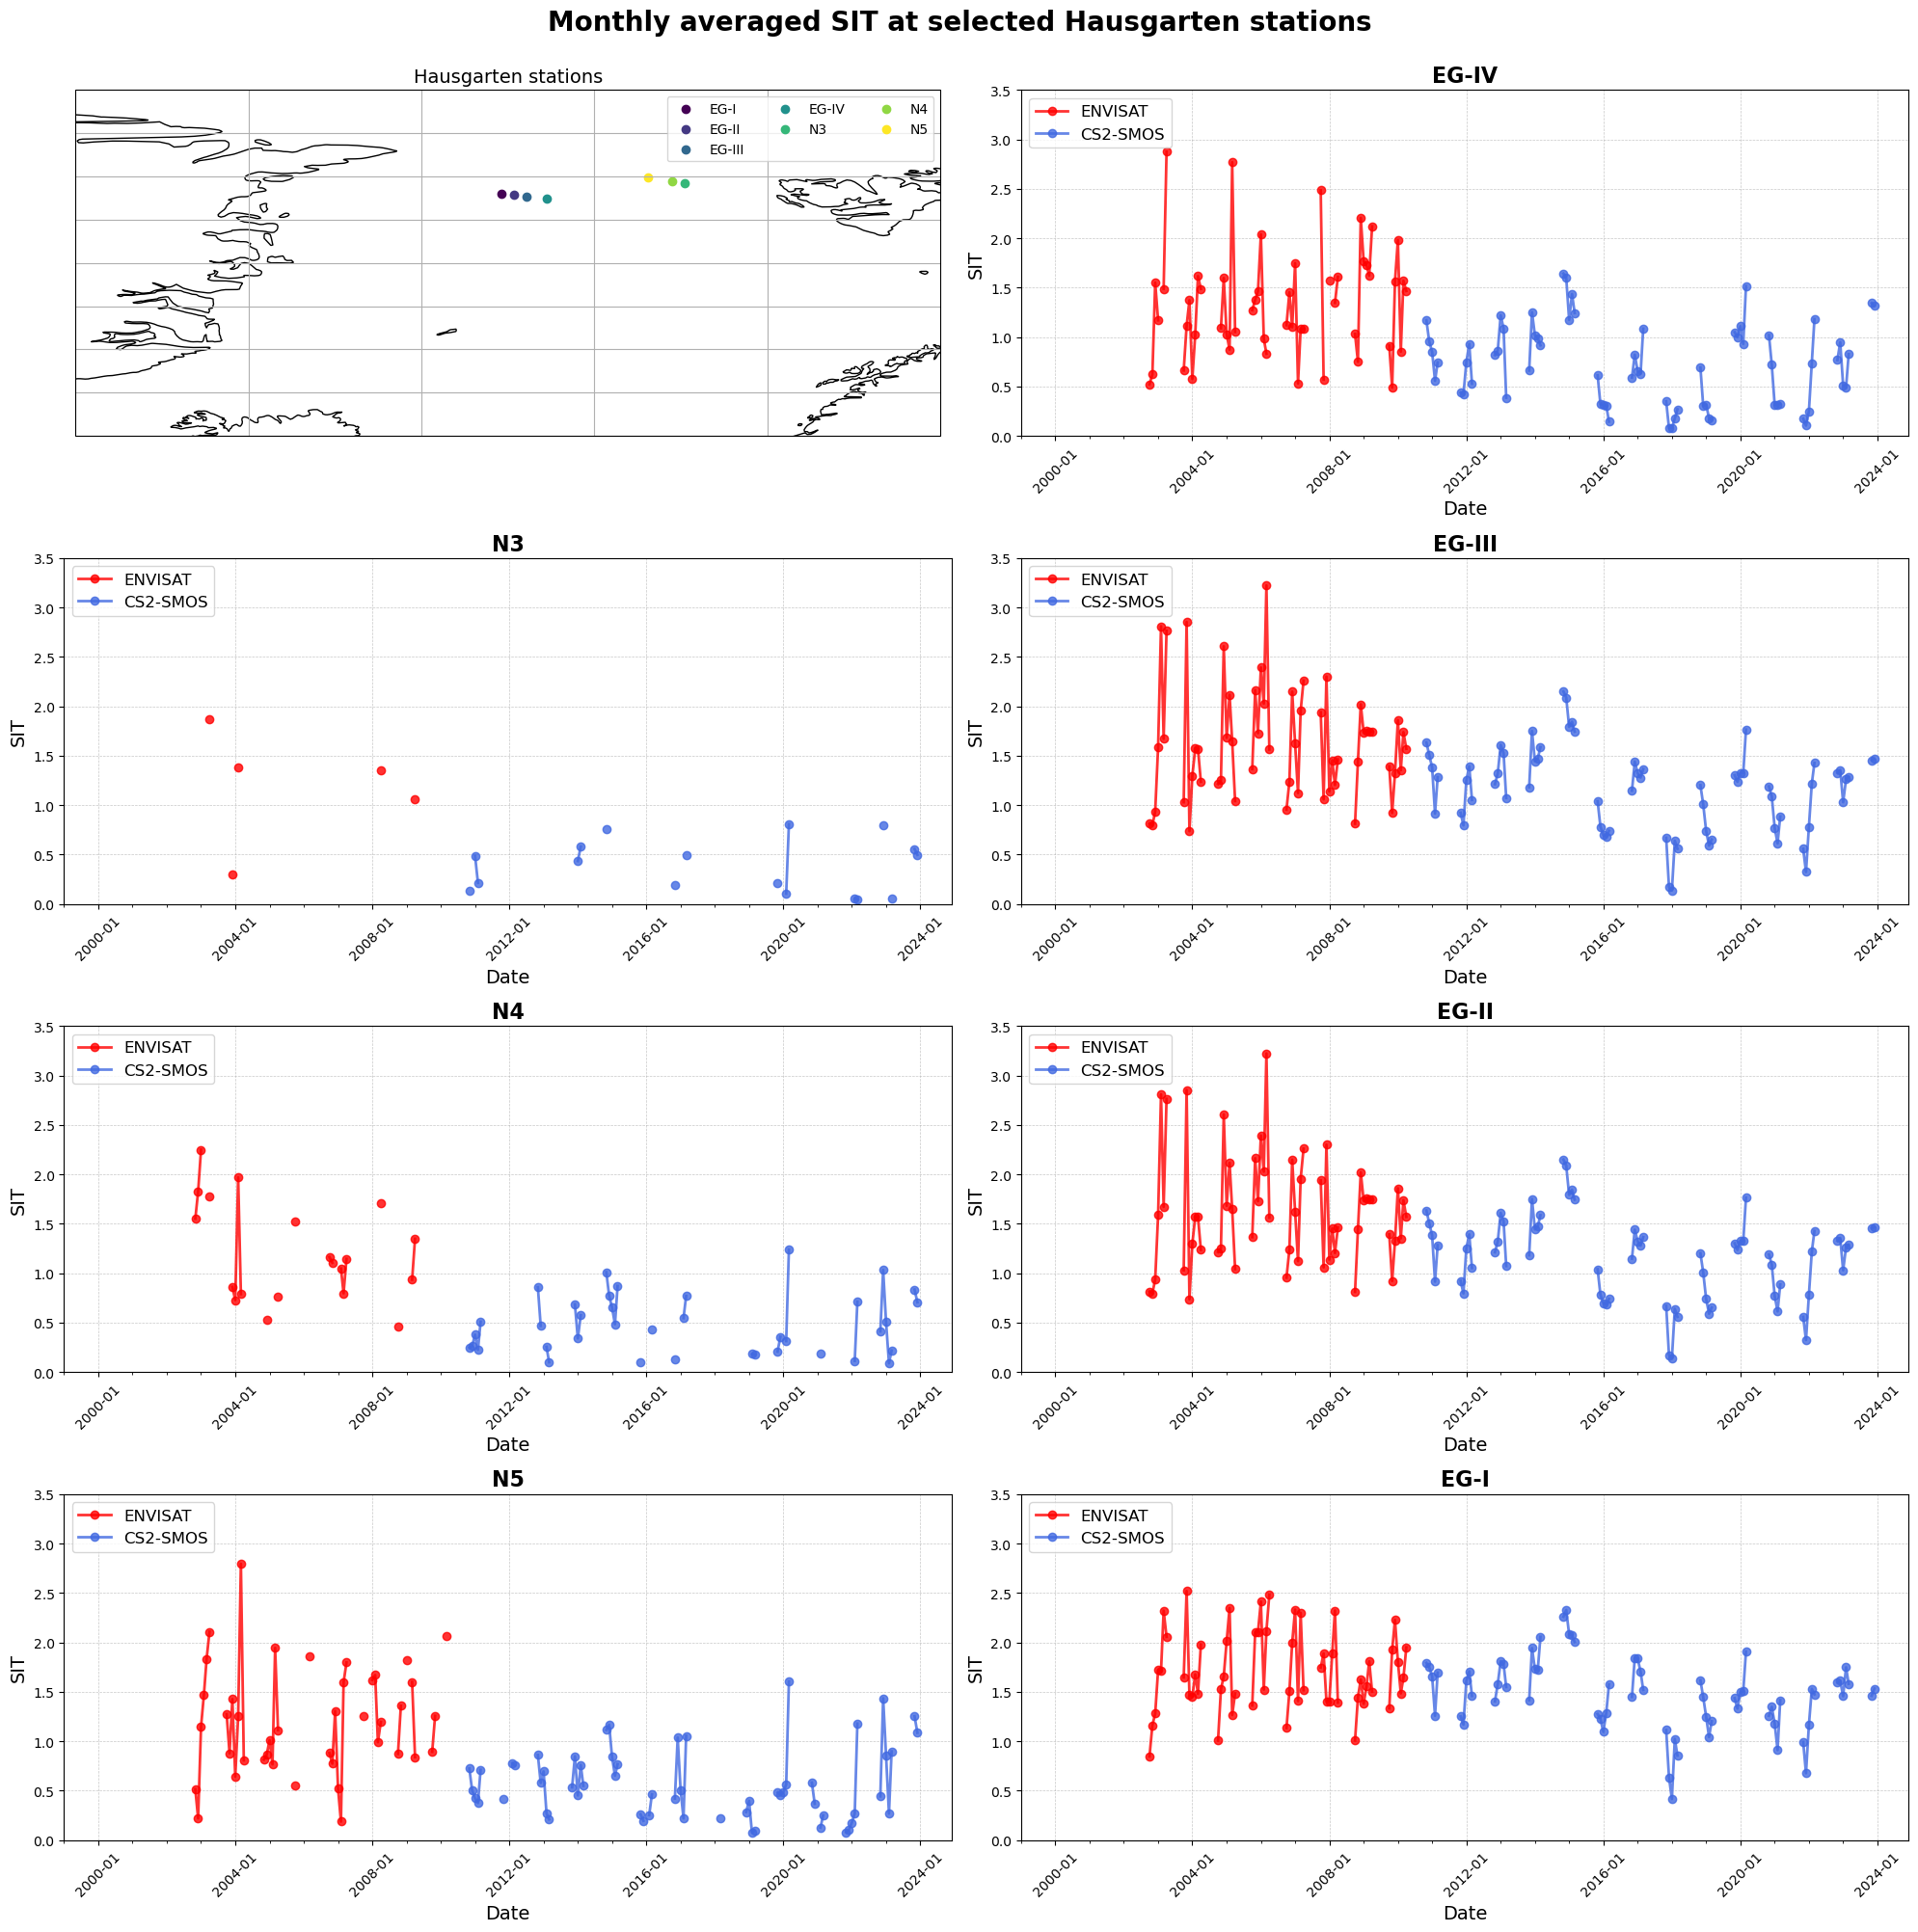

In [60]:
## Stations subplot
fig = plt.figure(figsize = (20,20))
fig.suptitle("Monthly averaged SIT at selected Hausgarten stations",fontweight = "bold",fontsize = 20,y = 1)
ax = fig.add_subplot(421,projection=ccrs.PlateCarree())
#ax = fig.add_subplot(421,projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
#ax.set_extent([-30, 30, 58,85],ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90))
design_map(ax,"Hausgarten stations",hemisphere = "nh",extent = [-30, 20, 65,85])

#sic_mean.plot(ax=ax, cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
#ax.pcolormesh(lon_2d, lat_2d, sic_mean, cmap='Blues_r', shading='auto',transform = ccrs.PlateCarree())
#fig.show()
#sys.exit()
for i,station_id in enumerate(station_ids):
    ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),color = viridis_colors[i],label = station_id)
    #ax.text(dfdict[station_id]["lon"][0],dfdict[station_id]["lat"][0],station_id, transform = ccrs.PlateCarree())
ax.legend(ncol = 3)    
for i,station_id in enumerate(station_ids_by_lon):
    
    if os.path.exists(os.path.join(datadir_csv,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv")):
        df_station = pd.read_csv(os.path.join(datadir_csv,f"hausgarten_sit_mean_{station_id}_{firstyear}-{lastyear}.csv"))
        df_station["sit_mean"][df_station["sit_mean"]>30] = np.nan
        ax = fig.add_subplot(421+axpos[i])
        makeplot(ax,df_station)

plt.tight_layout()
fig.savefig(os.path.join(plotdir,f"hausgarten_sit_mean_ALL_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
# Plot the mean values with error bars


# Show the plot

plt.show()

#### Compare means between stations

In [86]:
dfdict = get_dfdict(datadir_csv,station_ids,firstyear = firstyear,lastyear=lastyear)

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/1037457344.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_station["sit_mean"][df_station["sit_mean"]>30] = np.nan
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipyke

In [87]:
sit_mean_eg = np.zeros((4,dfdict["EG-I"].shape[0]))
sit_mean_n = np.zeros((3,dfdict["N3"].shape[0]))

In [88]:
stations_eg = [s for s in station_ids if s.startswith("EG")]
stations_n = [s for s in station_ids if s.startswith("N")]

In [89]:
for i,station_id in enumerate(stations_eg):
    sit_mean_eg[i,:] = dfdict[station_id]["sit_mean"]
for i,station_id in enumerate(stations_n):
    sit_mean_n[i,:] = dfdict[station_id]["sit_mean"]

In [90]:
date_range = pd.date_range(start=f'{firstyear}-01', end=f'{lastyear}-12', freq='MS')
cutoff_date = pd.Timestamp('2010-04')

# Mask the data based on the cutoff date
dates_envisat = date_range <= cutoff_date
dates_cs2smos = date_range > cutoff_date

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3122424017.py:5: RuntimeWarning: All-NaN slice encountered
  ax.plot(date_range[dates_envisat],np.nanmax(sit_mean_eg,axis = 0)[dates_envisat] - np.nanmin(sit_mean_eg,axis = 0)[dates_envisat],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3122424017.py:6: RuntimeWarning: All-NaN slice encountered
  ax.plot(date_range[dates_cs2smos],np.nanmax(sit_mean_eg,axis = 0)[dates_cs2smos] - np.nanmin(sit_mean_eg,axis = 0)[dates_cs2smos],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3122424017.py:10: RuntimeWarning: All-NaN slice encountered
  ax.plot(date_range[dates_envisat],np.nanmax(sit_mean_n,axis = 0)[dates_envisat] - np.nanmin(sit_mean_n,axis = 0)[dates_envisat],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alph

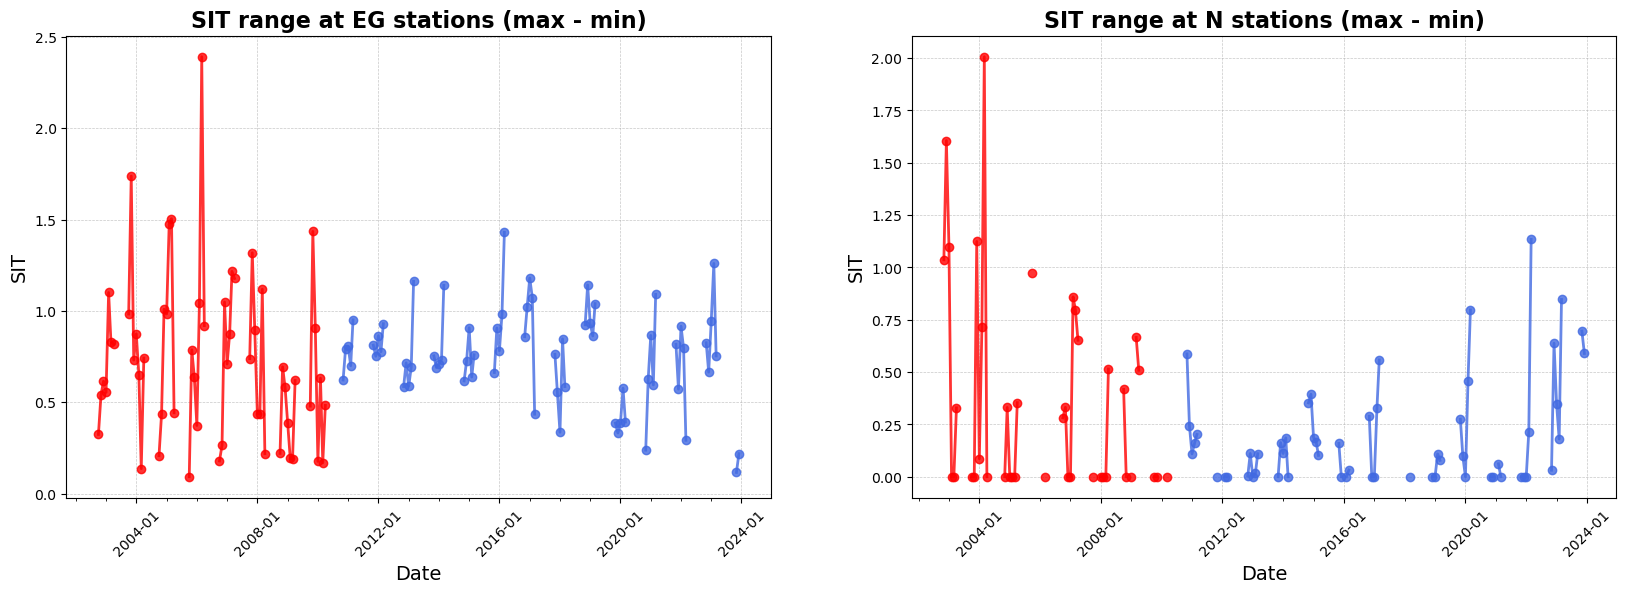

In [91]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
ax.set_title(f'SIT range at EG stations (max - min)', fontsize=16, fontweight='bold')
makenice(ax)
ax.plot(date_range[dates_envisat],np.nanmax(sit_mean_eg,axis = 0)[dates_envisat] - np.nanmin(sit_mean_eg,axis = 0)[dates_envisat],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax.plot(date_range[dates_cs2smos],np.nanmax(sit_mean_eg,axis = 0)[dates_cs2smos] - np.nanmin(sit_mean_eg,axis = 0)[dates_cs2smos],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax = fig.add_subplot(122)
ax.set_title(f'SIT range at N stations (max - min)', fontsize=16, fontweight='bold')
makenice(ax)
ax.plot(date_range[dates_envisat],np.nanmax(sit_mean_n,axis = 0)[dates_envisat] - np.nanmin(sit_mean_n,axis = 0)[dates_envisat],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
ax.plot(date_range[dates_cs2smos],np.nanmax(sit_mean_n,axis = 0)[dates_cs2smos] - np.nanmin(sit_mean_n,axis = 0)[dates_cs2smos],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
fig.savefig(os.path.join(plotdir,f"hausgarten_sit_range_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")

fig.show()

In [100]:
dt_array>pd.Timestamp("2010-04")

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3944883152.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3944883152.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/3944883152.py:8: SettingWithCopyWarning: 

SystemExit: ONE STATION

/Users/vludwig/opt/anaconda3/envs/sinxs/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


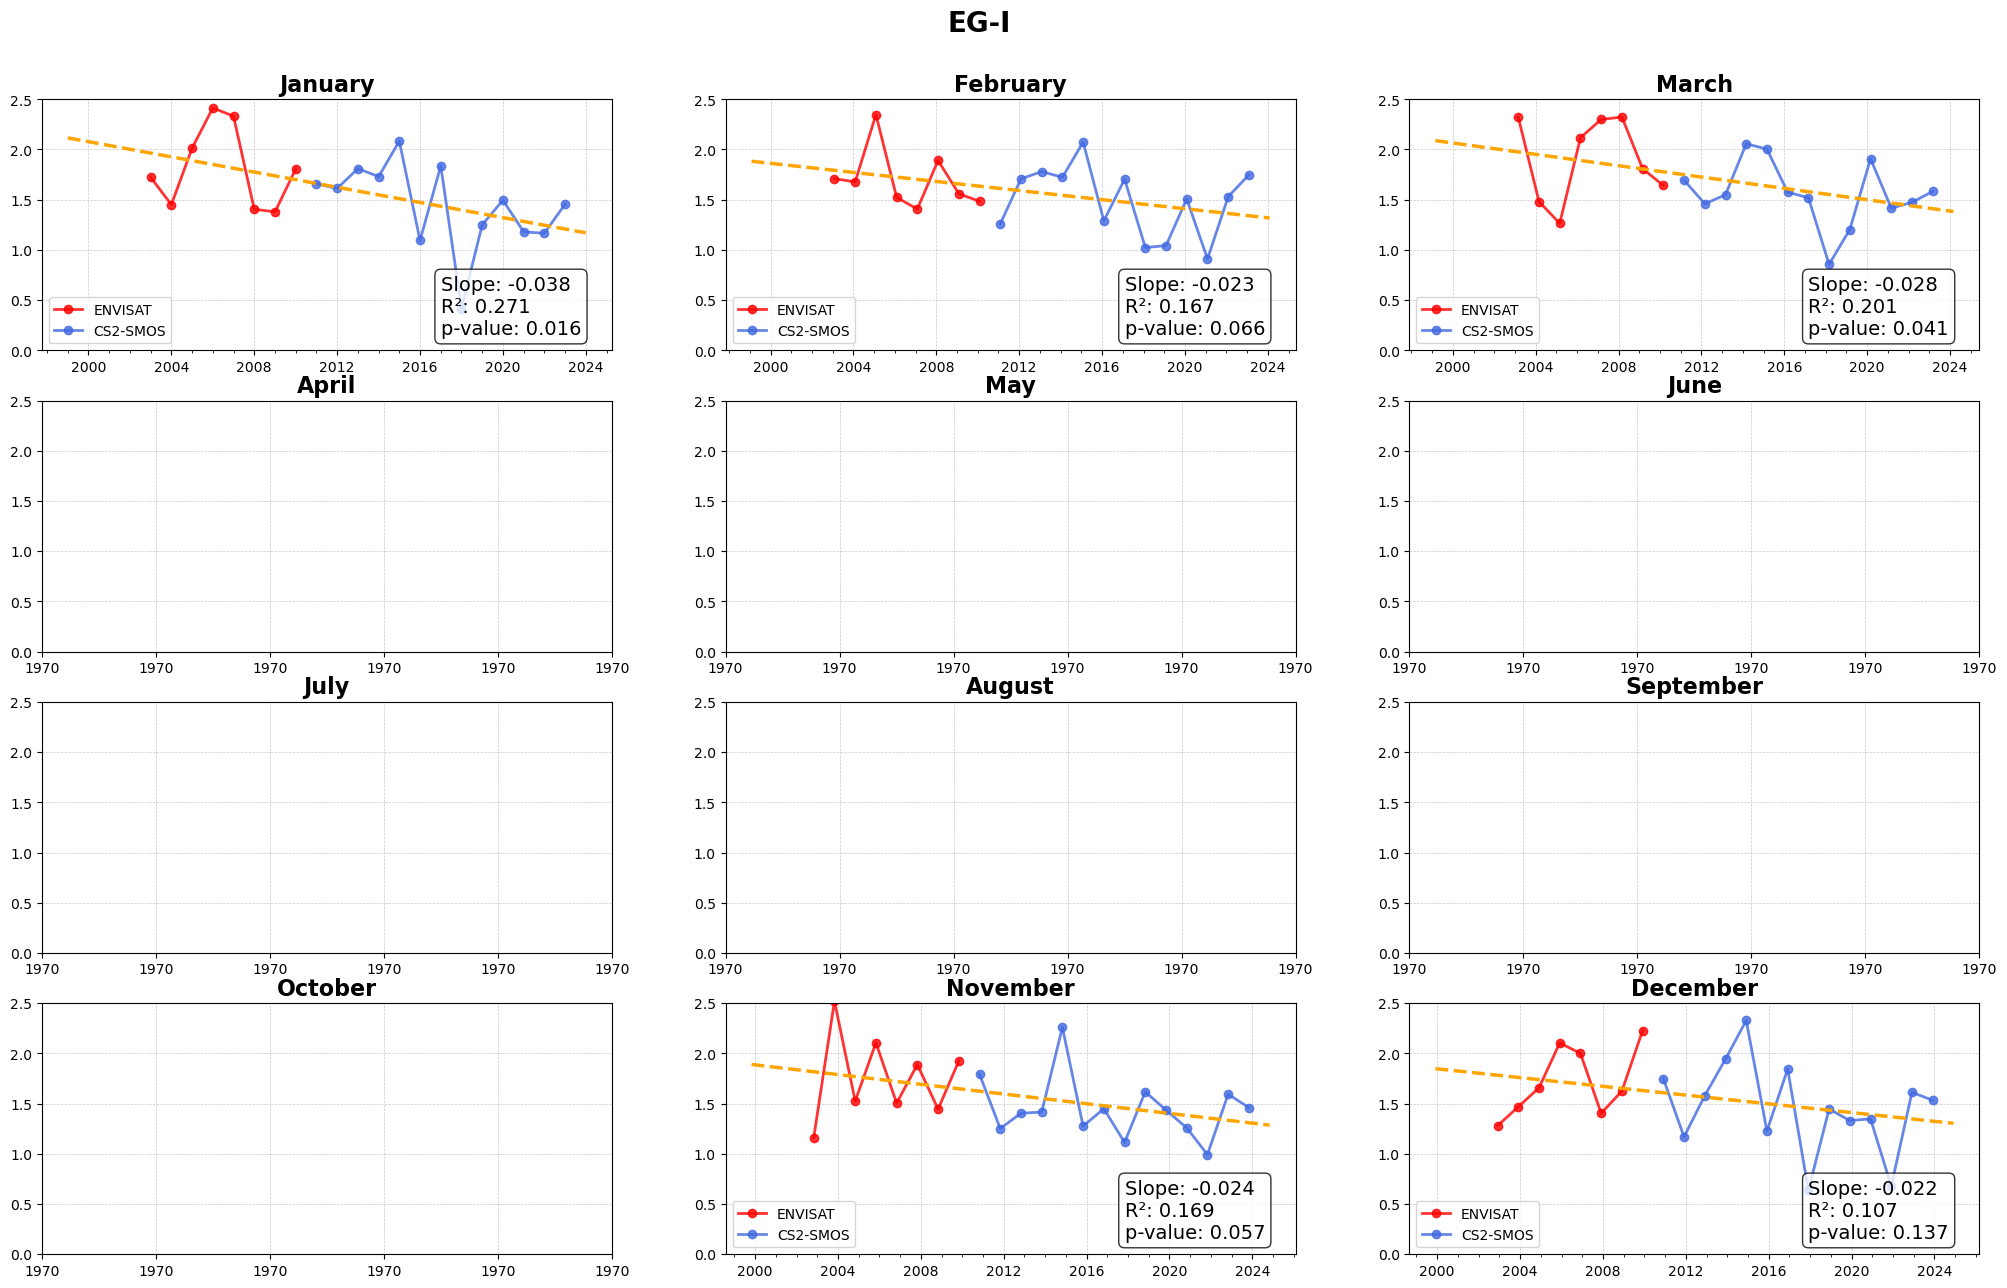

In [106]:
for station_id in station_ids:
    df_station = dfdict[station_id]
    fig = plt.figure(figsize = (25,15))
    fig.suptitle(f'{df_station["station_id"][0]}',fontweight = "bold",fontsize = 20,y = .94)

    for i,month in enumerate(range(1,13)):
        df_month = df_station[df_station["month"] == month]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
        # Extract the dt array for plotting
        dt_array = df_month['dt'].values
        cutoff = dt_array>pd.Timestamp("2010-04")
        ax = fig.add_subplot(4,3,month)
        ax.set_ylim((0,2.5))
        ax.set_title(f'{calendar.month_name[month]}', fontsize=16, fontweight='bold')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        # Improve x-axis formatting
        #plt.xticks(rotation=45)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Set major ticks to every year
        ax.xaxis.set_minor_locator(mdates.YearLocator())
        
        if not month in [1,2,3,11,12]:
            continue
        ax.plot(dt_array[dt_array<cutoff_date],df_month["sit_mean"][dt_array<cutoff_date],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8,label = "ENVISAT")
        ax.plot(dt_array[dt_array>=cutoff_date],df_month["sit_mean"][dt_array>=cutoff_date],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8,label = "CS2-SMOS")

        lr = linregress(df_month["year"][~np.isnan(df_month["sit_mean"])],df_month["sit_mean"][~np.isnan(df_month["sit_mean"])])
        #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
        ax.plot(dt_array,range(firstyear,lastyear+1)*lr.slope+lr.intercept, color='orange', linewidth=2.5, linestyle='--')
        stats_text = (f"Slope: {lr.slope:.3f}\n"
                       f"R²: {lr.rvalue**2:.3f}\n"
                       f"p-value: {lr.pvalue:.3f}")
        
        # Box properties for the text
        text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        
        # Add the text with a box around it
        ax.text(0.7, 0.3, stats_text,
                transform=ax.transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left',
                bbox=text_props)

        ax.legend(loc = "lower left")
    fig.savefig(os.path.join(plotdir,f"hausgarten_sit_mean_{station_id}_by_month_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
    #plt.close(fig)
    fig.show()
    sys.exit("ONE STATION")

#### Monthly plots for station average



##### Choose station below

In [123]:
True

True

In [124]:
treat_eg = True
treat_n = !treat_eg
if treat_eg:
    stations = stations_eg
    stationname = "EG"
else:
    stations = stations_n
    stationname = "N"

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/1127545680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/1127545680.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_97873/1127545680.py:10: SettingWithCopyWarnin

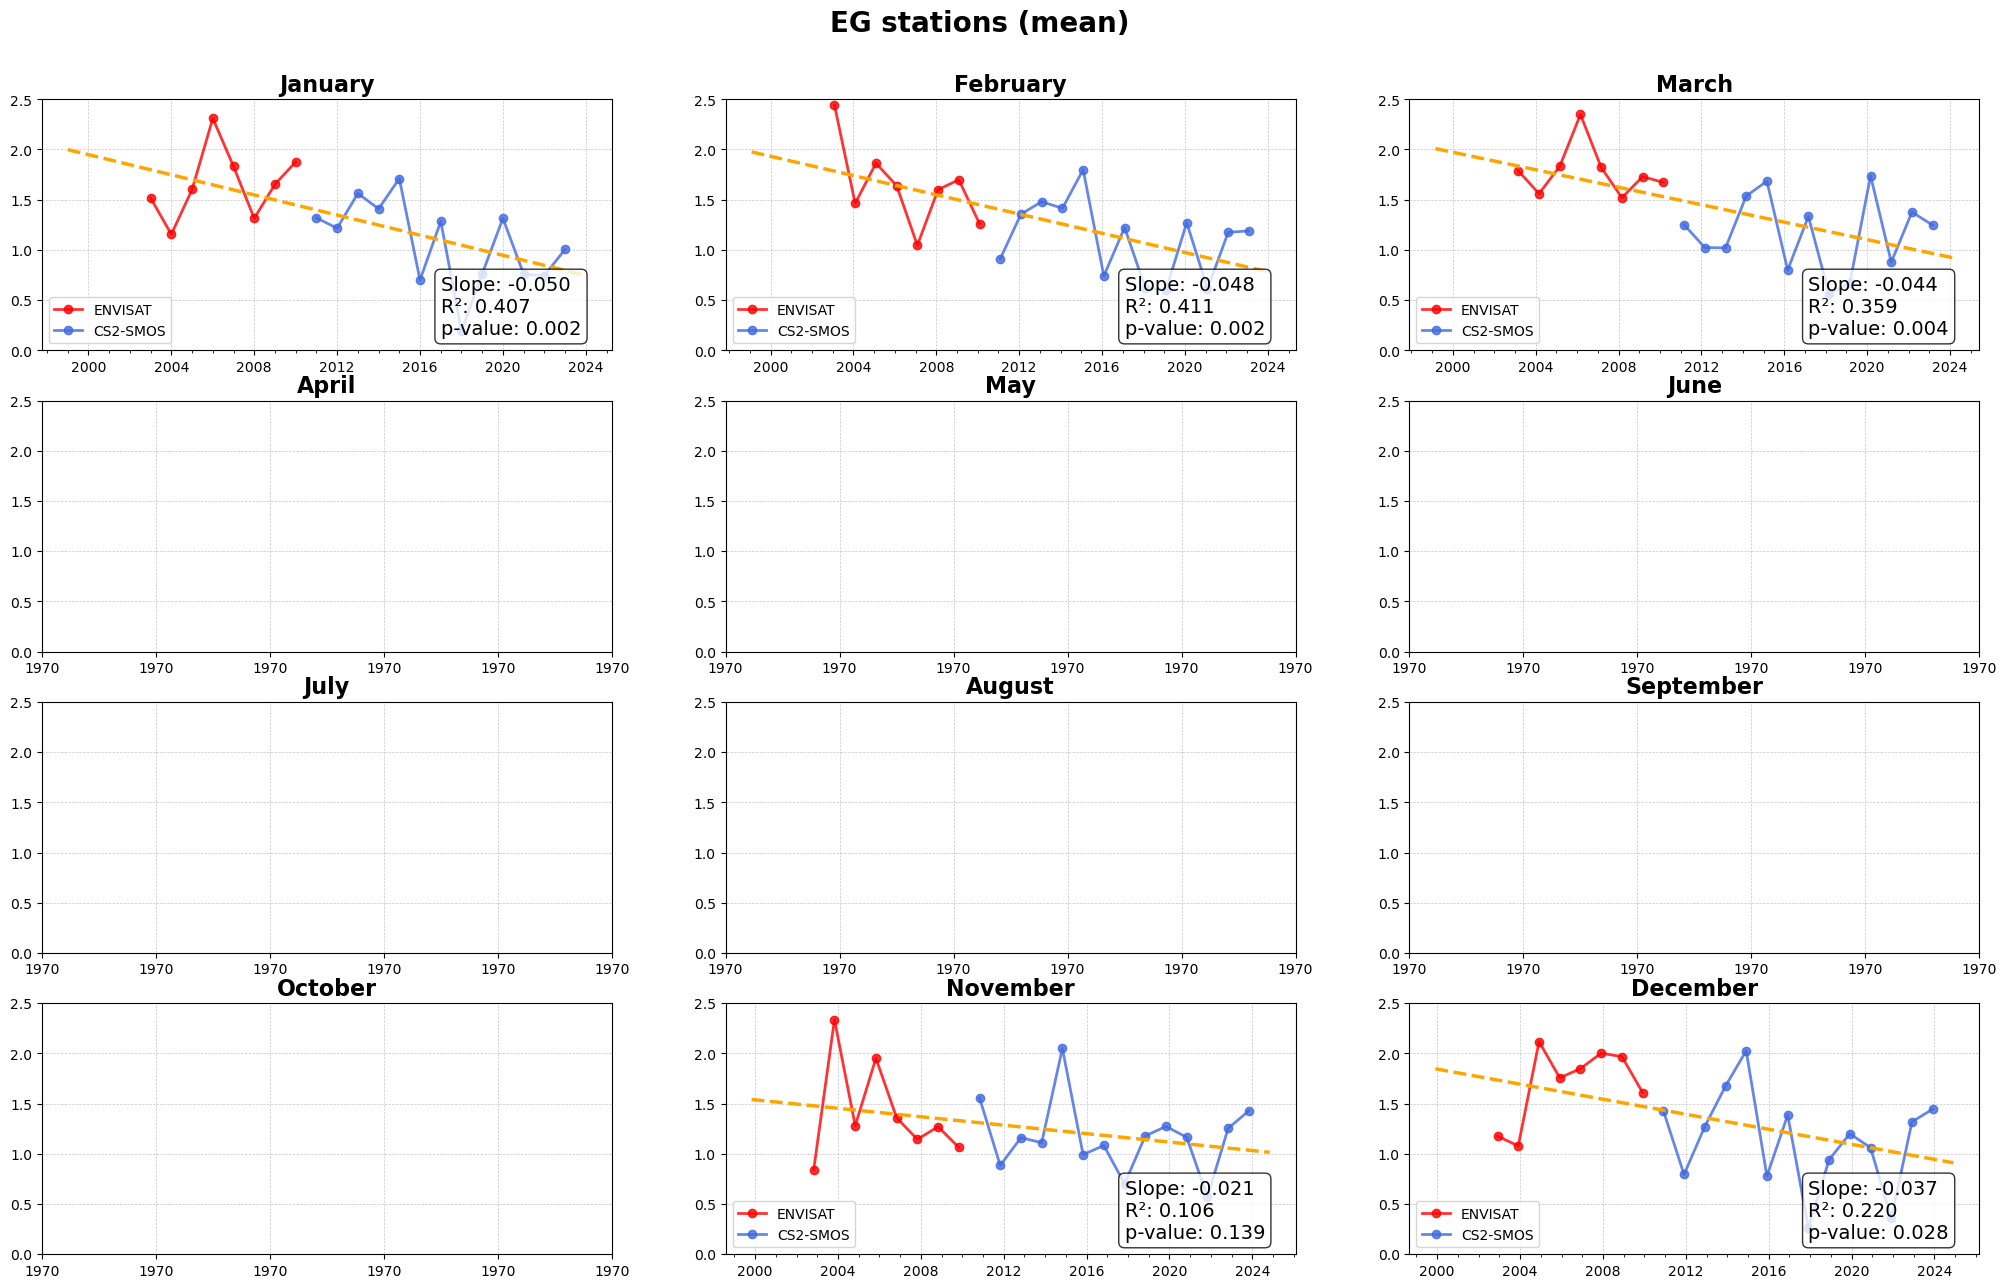

In [125]:

fig = plt.figure(figsize = (25,15))
fig.suptitle(f'{stationname} stations (mean)',fontweight = "bold",fontsize = 20,y = .94)

for i,month in enumerate(range(1,13)):
    sit_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(stations):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sit_month_stations[i,:] = df_month["sit_mean"]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
    sit_mean_stations = np.nanmean(sit_month_stations,axis = 0)
    #sys.exit()                                           
    # Extract the dt array for plotting
    dt_array = df_month['dt'].values
    
    ax = fig.add_subplot(4,3,month)
    ax.set_ylim((0,2.5))
    ax.set_title(f'{calendar.month_name[month]}', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    # Improve x-axis formatting
    #plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
    if not month in [1,2,3,11,12]:
        continue
    #ax.set_title(, fontsize=16, fontweight='bold')
    ax.plot(dt_array[dt_array<cutoff_date],sit_mean_stations[dt_array<cutoff_date],color='red', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8,label = "ENVISAT")
    ax.plot(dt_array[dt_array>=cutoff_date],sit_mean_stations[dt_array>=cutoff_date],color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8,label = "CS2-SMOS")

    lr = linregress(df_month["year"][~np.isnan(sit_mean_stations)],sit_mean_stations[~np.isnan(sit_mean_stations)])
    #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
    ax.plot(dt_array,range(firstyear,lastyear+1)*lr.slope+lr.intercept, color='orange', linewidth=2.5, linestyle='--')
    stats_text = (f"Slope: {lr.slope:.3f}\n"
                   f"R²: {lr.rvalue**2:.3f}\n"
                   f"p-value: {lr.pvalue:.3f}")
    
    # Box properties for the text
    text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    
    # Add the text with a box around it
    ax.text(0.7, 0.3, stats_text,
            transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left',
            bbox=text_props)
    ax.legend(loc = "lower left")
fig.show()
fig.savefig(os.path.join(plotdir,f"hausgarten_sit_mean_ALL_{stationname}_by_month_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
#plt.close(fig)
#

In [48]:

fig = plt.figure(figsize = (25,15))
fig.suptitle(f'{stationname} stations (mean)',fontweight = "bold",fontsize = 20,y = .94)

for i,month in enumerate(range(1,13)):
    sic_month_stations = np.zeros((len(stations),len(range(firstyear,lastyear+1))))
    for i,station_id in enumerate(stations):
        df_station = dfdict[station_id]
        df_month = df_station[df_station["month"] == month]
        sic_month_stations[i,:] = df_month["sic_mean"]
        df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
    sic_mean_stations = np.nanmean(sic_month_stations,axis = 0)
    #sys.exit()                                           
    # Extract the dt array for plotting
    dt_array = df_month['dt'].values
    
    ax = fig.add_subplot(4,3,month)
    #ax.set_title(, fontsize=16, fontweight='bold')
    ax.plot(dt_array,sic_mean_stations,color='royalblue', linestyle='-', marker='o', markersize=6, linewidth=2, alpha=0.8)
    ax.set_ylim((0,100))
    ax.set_title(f'{calendar.month_name[month]}', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    lr = linregress(df_month["year"][~np.isnan(sic_mean_stations)],sic_mean_stations[~np.isnan(sic_mean_stations)])
    #ax.text(0.75, 0.3, f"Slope: {lr.slope:.3f}", transform=ax.transAxes, fontsize=14, verticalalignment='top', horizontalalignment='left')
    ax.plot(dt_array,range(firstyear,lastyear+1)*lr.slope+lr.intercept, color='orange', linewidth=2.5, linestyle='--')
    stats_text = (f"Slope: {lr.slope:.3f}\n"
                   f"R²: {lr.rvalue**2:.3f}\n"
                   f"p-value: {lr.pvalue:.3f}")
    
    # Box properties for the text
    text_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    
    # Add the text with a box around it
    ax.text(0.7, 0.3, stats_text,
            transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left',
            bbox=text_props)

    # Improve x-axis formatting
    #plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Set major ticks to every year
    ax.xaxis.set_minor_locator(mdates.YearLocator())
fig.savefig(os.path.join(plotdir,f"hausgarten_sic_mean_ALL_{stationname}_by_month_{firstyear}-{lastyear}_{today}.pdf"),dpi = 150,bbox_inches = "tight")
plt.close(fig)
#fig.show()

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_85264/1663784406.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_85264/1663784406.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['dt'] = pd.to_datetime(df_month[['year', 'month']].assign(day=1))
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_85264/1663784406.py:10: SettingWithCopyWarnin